<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/pepijn/autoenc_repr_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import train
import utils

In [2]:
traintransform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testtransform = traintransform

batch_size = 32
num_workers = 2

trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
testloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Extracting /data/cifar10/train/cifar-10-python.tar.gz to /data/cifar10/train


Extracting /data/cifar10/test/cifar-10-python.tar.gz to /data/cifar10/test


In [3]:
imiter = iter(trainloader)
images, _ = next(imiter)
image = images[0]
images.shape

torch.Size([32, 3, 32, 32])

In [17]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)

        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x
        
enc = Encoder()
enc(images).shape

torch.Size([32, 32, 3, 3])

In [16]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop = nn.Dropout(0.2)

        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2)
        self.conv2 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2)
        self.conv3 = nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, output_padding=1)
    
    def forward(self, x):
        x = self.drop(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

decoder = Decoder()
decoder(enc(images)).shape

torch.Size([32, 3, 32, 32])

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoenc = AutoEncoder()
autoenc(images).shape

torch.Size([32, 3, 32, 32])

In [7]:
class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.drop = nn.Dropout(0.4)
        self.fc1 = nn.Linear(input_size, 
                             utils.intlerp(0.33, input_size, output_size))
        self.fc2 = nn.Linear(utils.intlerp(0.33, input_size, output_size), 
                          utils.intlerp(0.66, input_size, output_size))
        self.fc3 = nn.Linear(utils.intlerp(0.66, input_size, output_size), 
                          output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

mod = Classifier(10, 5)
mod(enc(images)).shape

torch.Size([32, 5])

In [20]:
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  )
  (decoder): Decoder(
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (conv2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (conv3): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  )
)

In [21]:
train.autotrain(model,
                optim.Adam(params=model.parameters(), lr=0.001),
                trainloader, testloader,
                nn.MSELoss(),
                epochs=5)

cuda
Epoch 0, Training loss: 339.7528396695852
Epoch 0, Validation loss: 315.7057189941406
Epoch 1, Training loss: 311.87117463350296
Epoch 1, Validation loss: 307.57208251953125
Epoch 2, Training loss: 288.41780246794224
Epoch 2, Validation loss: 274.1346740722656
Epoch 3, Training loss: 270.05359821766615
Epoch 3, Validation loss: 267.3231201171875
Epoch 4, Training loss: 265.54270401597023
Epoch 4, Validation loss: 264.3028564453125


torch.Size([32, 3, 32, 32])


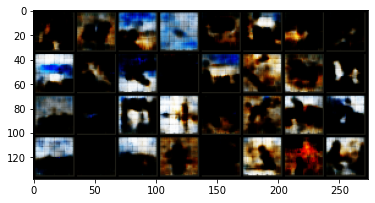

In [22]:

def showimage(image):
    image = image.detach().numpy()
    image = image.transpose((1, 2, 0))
    plt.imshow(image)
cpumodel = model.cpu()
out = cpumodel(images)
print(out.shape)
showimage(torchvision.utils.make_grid(out))
# showimage(torchvision.utils.make_grid(images))

In [ ]:

import importlib
utils = importlib.reload(utils)
train = importlib.reload(train)